
## Problem statement:
 - Explore the viability of algorithmic order location anticipation based on the data provided to guide the driver towards areas of highest ride value.
 - Build a documented simple baseline model.
 - Describe how you would deploy such a model.
 - Think through and describe the randomized experiment (AB-test) for live operations.

## Adding imports



In [1]:
import os.path
import pickle

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Loading data frame and having a look at the data


In [2]:
data_frame = pd.read_csv('robotex5.csv', parse_dates=['start_time'])
data_frame['start_time'] = pd.to_datetime(data_frame['start_time'])
data_frame.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


In [3]:
data_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_time  627210 non-null  datetime64[ns]
 1   start_lat   627210 non-null  float64       
 2   start_lng   627210 non-null  float64       
 3   end_lat     627210 non-null  float64       
 4   end_lng     627210 non-null  float64       
 5   ride_value  627210 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 28.7 MB


In [4]:
data_frame.isna().any()

start_time    False
start_lat     False
start_lng     False
end_lat       False
end_lng       False
ride_value    False
dtype: bool

In [5]:
data_frame.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


## Creating a class to Transform data for EDA


In [6]:
class RideValueTransformer(BaseEstimator, RegressorMixin, TransformerMixin):

    def transform(self, X):
        """This transforms the dataframe to the desired
         features and shape"""
        X['pickup_time'] = self.__add_time_feature(X)
        X['weekday'] = self.__add_weekdays_feature(X)
        X = self.__add_travel_features(X)
        X['distance'] = np.round(self.__add_distance_feature(X), 2)
        X = self.__drop_unrequired_fields(X)
        X = self.__normalize(X)
        return X

    def __add_travel_features(self, X):
        X['abs_diff_longitude'] = (X.end_lng - X.start_lng).abs()
        X['abs_diff_latitude'] = (X.end_lat - X.start_lat).abs()
        return X

    def __add_time_feature(self, X):
        return X['start_time'].dt.hour

    def __add_weekdays_feature(self, X):
        return X['start_time'].dt.day_of_week

    def __add_distance_feature(self, X):
        """Method for calculating distance from start lat/long to end lat/long"""
        radius_of_earth = 6373.0
        lat1 = np.asarray(np.radians(X['start_lat']))
        lon1 = np.asarray(np.radians(X['start_lng']))
        lat2 = np.asarray(np.radians(X['end_lat']))
        lon2 = np.asarray(np.radians(X['end_lng']))

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = radius_of_earth * c

        distance_array = np.asarray(distance) * 0.621
        return pd.Series(distance_array)

    def __drop_unrequired_fields(self, X):
        return X.drop(['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)

    def __normalize(self, X):
        X['abs_diff_longitude'] = np.abs(
            X['abs_diff_longitude'] - np.mean(X['abs_diff_longitude']))
        X['abs_diff_longitude'] = X['abs_diff_longitude'] / np.var(X['abs_diff_longitude'])

        X['abs_diff_latitude'] = np.abs(
            X['abs_diff_latitude'] - np.mean(X['abs_diff_latitude']))
        X['abs_diff_latitude'] = X['abs_diff_latitude'] / np.var(X['abs_diff_latitude'])
        return X


In [7]:
model_transformer =  RideValueTransformer()
data_frame = model_transformer.transform(data_frame)
data_frame.head()


,ride_value,pickup_time,weekday,abs_diff_longitude,abs_diff_latitude,distance
0,3.51825,15,6,0.014954,0.026555,8.80
1,0.50750,11,3,0.029851,0.019932,1.27
2,0.19025,14,6,0.033014,0.025979,0.48
3,0.75600,9,3,0.030962,0.014438,1.89
4,2.27100,0,6,0.007846,0.000263,5.70


## Now let's quickly plot travel vector features to see their distribution
### We check the value of 'abs_diff_longitude', 'abs_diff_latitude'

<AxesSubplot:xlabel='abs_diff_longitude', ylabel='abs_diff_latitude'>

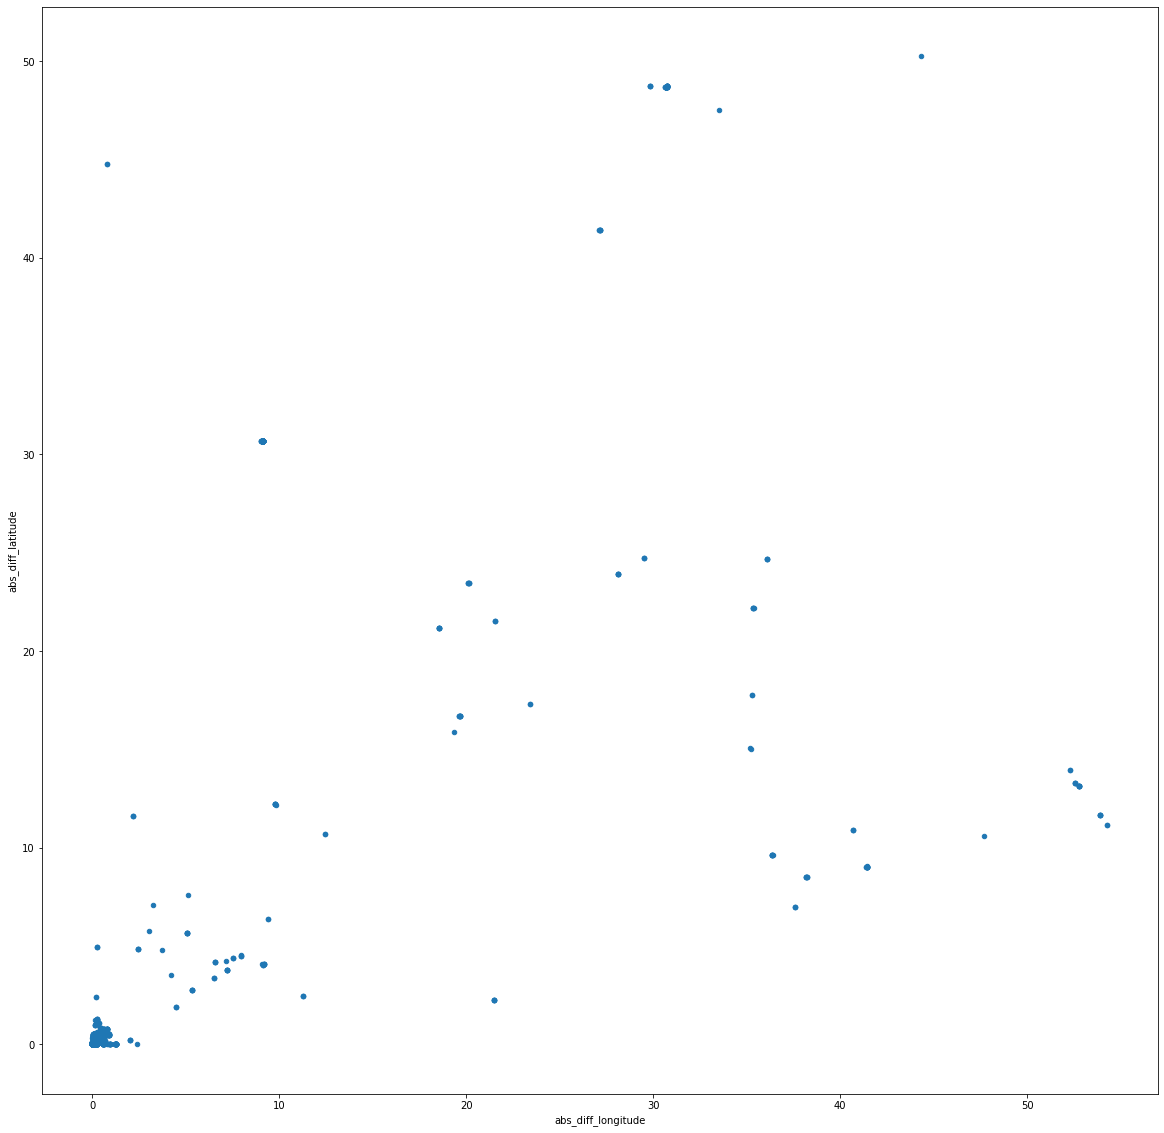

In [8]:
data_frame.plot.scatter('abs_diff_longitude', 'abs_diff_latitude', figsize=(20, 20))

### Observation based on the above graph: Need to remove the outlier from the data so that it does not influence training set

## Observing the ride value column

array([[<AxesSubplot:title={'center':'ride_value'}>]], dtype=object)

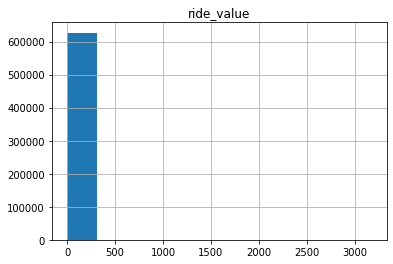

In [9]:
data_frame.hist('ride_value')

## Observation: Based on the above graph there are some outliers because of which the graph is not looking correct


## We create a class to remove the outliers


In [10]:
class CleanData:

    def removing_outliers_for_distance(self, X):
        P1 = np.percentile(X.abs_diff_longitude, [5, 95])
        P2 = np.percentile(X.abs_diff_latitude, [5, 95])
        result_df = X[(X.abs_diff_longitude > P1[0]) & (X.abs_diff_longitude < P1[1])]
        return result_df[(result_df.abs_diff_latitude > P2[0]) & (result_df.abs_diff_latitude < P2[1])]

### Now removing the outliers based on our  observation

In [11]:
print('Old size: %d' % len(data_frame))
data_cleaner = CleanData()
data_frame = data_cleaner.removing_outliers_for_distance(data_frame)
print('New size: %d' % len(data_frame))

Old size: 627210
New size: 511735


### Re-observing the data after removing the outliers

<AxesSubplot:xlabel='abs_diff_longitude', ylabel='abs_diff_latitude'>

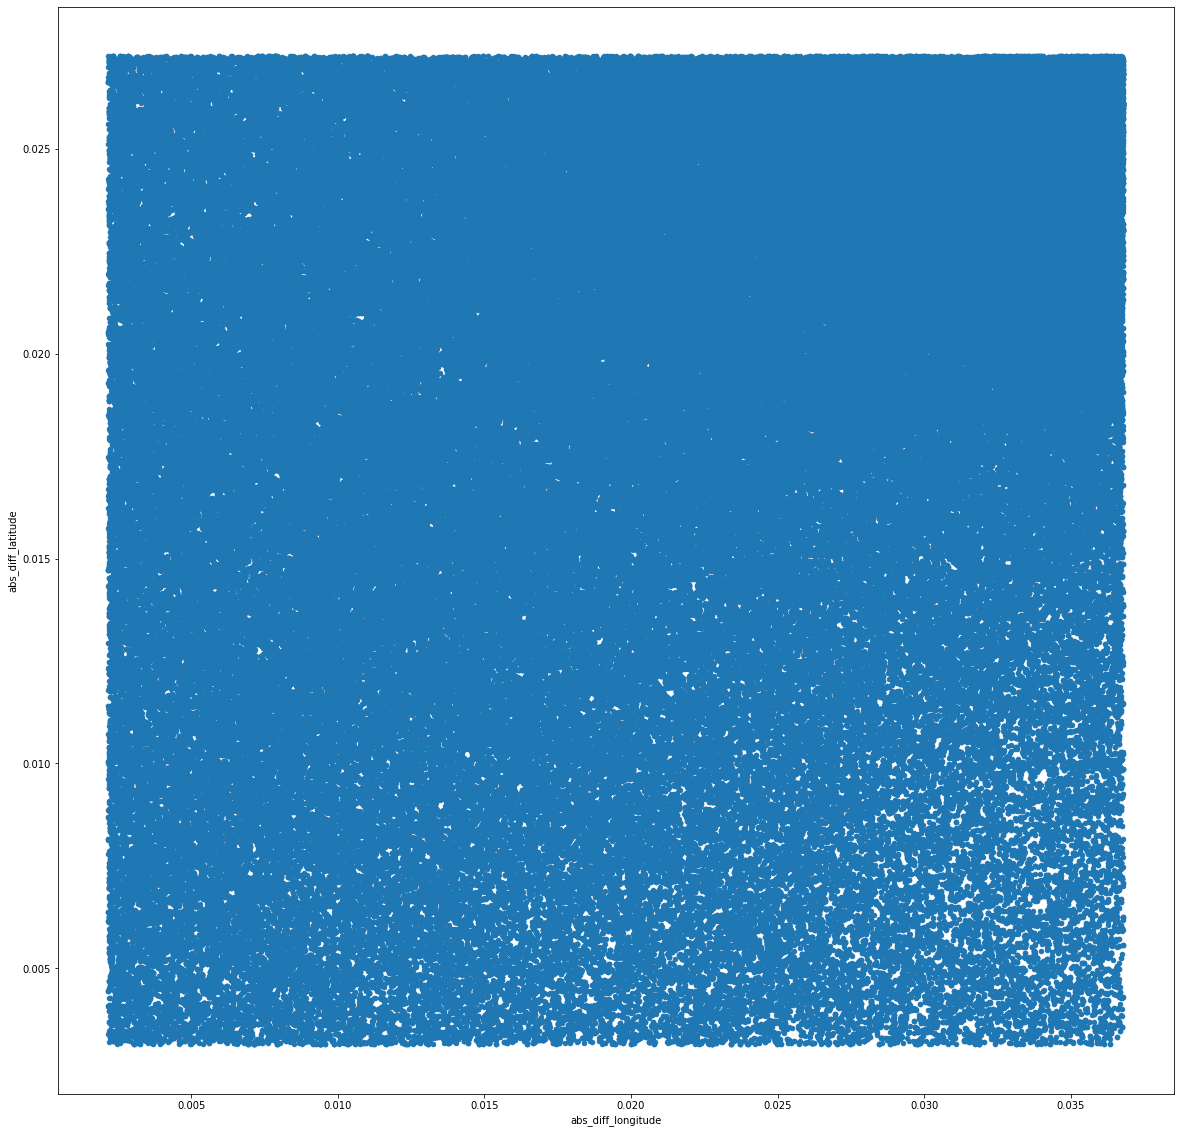

In [12]:
data_frame.plot.scatter('abs_diff_longitude', 'abs_diff_latitude', figsize=(20, 20))


### Also observing the graph for ride_value

array([[<AxesSubplot:title={'center':'ride_value'}>]], dtype=object)

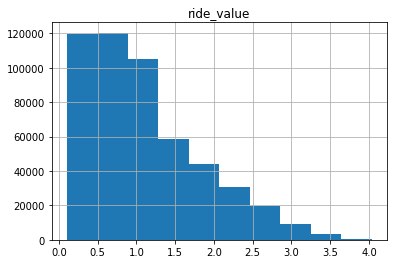

In [13]:
data_frame.hist('ride_value')


### Data now looks cleaner

## Creating Baseline model to predict the ride_value based on the data_frame

In [14]:
class ValueEstimator(BaseEstimator, RegressorMixin):
    """Value estimator based on the parameters specified as constructor parameter.
    This class will attempt to load a previously saved model.
     """

    def __init__(self, fileName="ValueEstimator.model", alwaysCreateNew=False, model_params=None):
        if model_params is None:
            model_params = {}
        self.__lgb_df = None
        self.__fileName = fileName
        self.__alwaysCreateNew = alwaysCreateNew
        self.__model = None
        if model_params is None:
            self.__model_params = {}
        else:
            self.__model_params = model_params

        if os.path.exists(self.__fileName) and not alwaysCreateNew:
            with open(self.__fileName, "rb") as modelFile:
                self.__model = pickle.load(modelFile)

    def fit(self, X, y):
        """This method trains the model based on data provided and will
        override any previously loaded value in the current object"""
        lgb_df = lgb.Dataset(X, y)
        self.__model = lgb.train(params=self.__model_params, train_set=lgb_df)
        return self

    def score(self, X, y, sample_weight=None) -> float:
        """Returns the score Root means square"""
        predicted_value = self.__model.predict(X)
        return np.sqrt(mean_squared_error(y, predicted_value))

    def predict(self, X):
        return self.__model.predict(X)

    def save(self):
        """This function will attempt to save the model on disk specified as per location mentioned
        in fileName parameter of constructor"""
        with open(self.__fileName, "wb") as modelFile:
            pickle.dump(self.__model, modelFile)

### Adding the estimator

In [15]:
ride_value_estimator = ValueEstimator()
X = data_frame.drop(columns=['ride_value'], axis=1)
y = data_frame['ride_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

ride_value_estimator.fit(X_train, y_train)

rmse = ride_value_estimator.score(X_test, y_test)

print("Root Mean Square Error = {}".format(rmse))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 409388, number of used features: 5
[LightGBM] [Info] Start training from score 1.107035
Root Mean Square Error = 0.005090575319560777


#### As mentioned in the problem statement, I am sharing my thoughts on deployment strategy
- Create and save the model on a location by invoking ValueEstimator::save()
- Package the above created classes into a project and expose them using Flask REST api and receive the data at runtime
- It would also be a good idea to package the project within a docker container so that the code is independent of the deployment environment.

#### A simple flask code would look like this



```
@app.route('/predict-ride-value', methods=['POST'])
def ride_value_estimator():
    content_type = request.headers.get('Content-Type')
    if content_type == 'application/json':
        json = request.get_json()
        data_frame = pd.DataFrame(request.get_json())
        data_frame['start_time'] = pd.to_datetime(data_frame['start_time'])
        df_transformer = RideValueTransformer()
        data_frame = df_transformer.transform(data_frame)
        estimator = ValueEstimator(fileName="data/ValueEstimator.model")
        estimated_ride_values = estimator.predict(data_frame).tolist()
        for i in range(len(json)):
            json[i]['estimated_ride_values'] = estimated_ride_values[i]
        return jsonify(json)
    else:
        return 'Content-Type not supported!'
```

Sample Curl Request:

```
curl --location --request POST 'http://localhost:5000/predict-ride-value' \
--header 'Content-Type: application/json' \
--data-raw '[{
    "start_time" : "2022-03-06 19:02:39.329452000",
    "start_lat" : 69.4349404406161,
    "start_lng" :  24.753641074745016,
    "end_lat" :  59.42644990771725,
    "end_lng" : 24.78307556940856
},
{
    "start_time" : "2022-03-06 15:02:39.329452000",
    "start_lat" : 59.4349404406161,
    "start_lng" :  24.753641074745016,
    "end_lat" :  59.42644990771725,
    "end_lng" : 24.78307556940856
}]

'
```

Sample Response:

```
[
    {
        "end_lat": 59.42644990771725,
        "end_lng": 24.78307556940856,
        "estimated_ride_values": 3.6343977031255292,
        "start_lat": 69.4349404406161,
        "start_lng": 24.753641074745016,
        "start_time": "2022-03-06 19:02:39.329452000"
    },
    {
        "end_lat": 59.42644990771725,
        "end_lng": 24.78307556940856,
        "estimated_ride_values": 0.4678476685288752,
        "start_lat": 59.4349404406161,
        "start_lng": 24.753641074745016,
        "start_time": "2022-03-06 15:02:39.329452000"
    }
]
```


#### I have created an image for the same by  pasting the above mentioned classes and exposing the methods using Flask API.Following are the steps to run the API:
- Make sure docker is running on the system
- On terminal run ``` docker run -d -p 5000:5000 kanikasharma13/ride-value-estimator-api ```
- Copy  the sample curl request on terminal (or copy the json mentioned in the sample request to postman and post the data raw json to http://localhost:5000/predict-ride-value)
- In the response   you would see the json containing following value "estimated_ride_values" which is the predicted ride value.




### As a part of  the problem statement, for AB- test for live operations, I would be saving the prediction in DB and then comparing the data against actual ride value. This comparison could be done monthly and check how the system is performing. Root Mean Square Error could be used as a KPI for measuring the performance of the system.


### Improvements-
- The parameters of the lgbm can be tuned using hyper-parameter optimisation techniques.
- Add a new method to the API for reloading the model without restarting the server

### Additional data which could help to improve the accuracy:
- An additional flag indicating peak hours and holidays
- Actual distance to travel will help in better estimation as difference between start and end lat/long's is just giving us displacement which could be different from actual distance.
- Information regarding any event (like parade or no vehicle day etc.) happening between the start and end locations would also be helpful.

### References
1. Formula to calculate distance from 2 pairs of longitude and latitude
https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula